In [111]:
import pandas as pd
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import matplotlib.pyplot as plt
from gensim.models import Word2Vec, Phrases
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess
from gensim import corpora, models
import spacy
import string
import gensim
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import seaborn as sns

Trying to separate the video searches to their appropriate companies

In [133]:
df1 = pd.read_csv('df1_combined.csv')
df2 = pd.read_csv('df2_combined.csv')

/var/folders/yt/slyrm7113271w310_rtxsbnw0000gn/T/ipykernel_37933/514336858.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('df2_combined.csv')


Associating the comments and videos to their appropriate companies

In [134]:
company_keywords = {
    'Abarth': ['Abarth', 'abarth', 'ABARTH'],
    'Fiat': ['Fiat', 'fiat', 'FIAT'],
    'Mini': ['Mini', 'mini', 'MINI'],
    'Peugeot': ['Peugeot', 'peugeot', 'PEUGEOT'],
    'Volkswagen': ['Volkswagen', 'volkswagen', 'VW', 'vw', 'Vw'],
    'Tesla': ['Tesla', 'tesla', 'TESLA']
}

def assign_company(row):
    for company, keywords in company_keywords.items():
        if any(keyword in str(row['Post_Title']) or keyword in str(row['Post_Content']) for keyword in keywords):
            return company
    return 'Unknown'

df1['Company'] = df1.apply(assign_company, axis=1)

In [135]:
df1[df1['Company'] == 'Unknown'].head()

,Post_id,Post_Title,Author,Date,Post_Content,Comment_Number,Net_Like,Views,Company
53,GI9pkcFJXV4,All about the Taurozzi Pendulum Engine 🧠 and w...,Repairman22,2023-01-21T14:00:08Z,In this video we analyze the Taurozzi pendulum...,2371,31430,1540034,Unknown
54,9lse1SfDq7M,Engine lubrication system / How does it work? ...,CARinfo3d (En),2022-12-07T13:47:38Z,The internal combustion engine contains numero...,66,4153,165024,Unknown
60,W94iksaQwUo,How Ignition System Works,Automotive System,2012-08-13T12:55:59Z,Know the basic working of an automobile igniti...,949,32122,4814980,Unknown
61,90uUdwJBEu4,Learn about every Engine Layout in just one vi...,The Engineers Post,2023-01-02T13:16:16Z,Straight/Inline engine:\nThe straight or inlin...,204,7424,380541,Unknown
64,x70VqMrXrbs,Car Engine Parts & Their Functions Explained i...,The Engineers Post,2021-04-17T11:39:00Z,List of Car Engine Parts | TheEngineersPost\n\...,793,109477,4054744,Unknown


Associating the df2 comments to the videos from df1 using the Post_id

In [136]:
#Mapping to df2 to remove unwanted video comments
merged_df2 = df2.merge(df1[['Post_id', 'Company']], on='Post_id', how='left')

In [137]:
merged_df2.head()

,Unique_id,Post_id,Author,Date,Comment_Content,Reply_id,Reply_Count,Parent_id,Company
0,UgwxZe_9rq6Divz2B6V4AaABAg,eQlcDSnItRk,Tomas Juricek,2023-05-27T08:14:43Z,Not more car,0.0,NaN,NaN,Abarth
1,UgyaJ0l-wY032jA6YsR4AaABAg,eQlcDSnItRk,Todd Turner,2023-05-21T12:25:06Z,If Hydrocarbons came from dinosaurs how many o...,0.0,NaN,NaN,Abarth
2,Ugxp60x3am7lNpJjYt94AaABAg,eQlcDSnItRk,PoltergeistWorks,2023-05-20T19:08:31Z,"Less power, less range, fake noise and twice t...",0.0,NaN,NaN,Abarth
3,UgxfZcCbo05HhzRi1Ht4AaABAg,eQlcDSnItRk,Spooligan,2023-05-17T10:54:08Z,TF?!? 96mph? A prius does 0 to 60 faster than ...,0.0,NaN,NaN,Abarth
4,UgxZboo7_6pqKXGUAt94AaABAg,eQlcDSnItRk,Miguel Afonso,2023-05-16T22:44:14Z,"Even slower that a 595 I reckon, and you can h...",0.0,NaN,NaN,Abarth


In [138]:
#Checking the length of the Unknown in df1 and df2
print(len(df1[df1['Company'] == 'Unknown']))
print(len(merged_df2[merged_df2['Company']=='Unknown']))

33
26380


In [139]:
#Dropping the NaN values
merged_df2 = merged_df2.dropna(subset=['Comment_Content'])

#Dropping Unknown in Company
merged_df1 = df1[df1['Company'] != 'Unknown']
merged_df2 = merged_df2[merged_df2['Company'] != 'Unknown']

**Dealing with different languages in comments of df2**

In [140]:
#Library is used for detecting the language
from langdetect import detect

#Function used for running the comments through to detect the language
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

#Creates a new column 'language' in merged_df2 to detect the language in the comment
merged_df2['language'] = merged_df2['Comment_Content'].apply(detect_language)

In [141]:
merged_df2.head()

,Unique_id,Post_id,Author,Date,Comment_Content,Reply_id,Reply_Count,Parent_id,Company,language
0,UgwxZe_9rq6Divz2B6V4AaABAg,eQlcDSnItRk,Tomas Juricek,2023-05-27T08:14:43Z,Not more car,0.0,NaN,NaN,Abarth,ro
1,UgyaJ0l-wY032jA6YsR4AaABAg,eQlcDSnItRk,Todd Turner,2023-05-21T12:25:06Z,If Hydrocarbons came from dinosaurs how many o...,0.0,NaN,NaN,Abarth,en
2,Ugxp60x3am7lNpJjYt94AaABAg,eQlcDSnItRk,PoltergeistWorks,2023-05-20T19:08:31Z,"Less power, less range, fake noise and twice t...",0.0,NaN,NaN,Abarth,en
3,UgxfZcCbo05HhzRi1Ht4AaABAg,eQlcDSnItRk,Spooligan,2023-05-17T10:54:08Z,TF?!? 96mph? A prius does 0 to 60 faster than ...,0.0,NaN,NaN,Abarth,en
4,UgxZboo7_6pqKXGUAt94AaABAg,eQlcDSnItRk,Miguel Afonso,2023-05-16T22:44:14Z,"Even slower that a 595 I reckon, and you can h...",0.0,NaN,NaN,Abarth,en


In [142]:
#Saving the file
#merged_df1.to_csv('merged_df1.csv', index=False)
#merged_df2.to_csv('merged_df2.csv', index=False)

LOADING THE LATEST FILES (Checkpoint purposes)

In [147]:
#Loading the file
merged_df1 = pd.read_csv('merged_df1.csv')
merged_df2 = pd.read_csv('merged_df2.csv')

/var/folders/yt/slyrm7113271w310_rtxsbnw0000gn/T/ipykernel_37933/706945961.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df2 = pd.read_csv('merged_df2.csv')


In [148]:
print(len(merged_df1))
print(len(merged_df2))

470
123156


In [149]:
print(len(merged_df1[merged_df1['Company']=='Unknown']))
print(len(merged_df2[merged_df2['Company']=='Unknown']))

0
0


***Data Cleaning Process***

Dropping duplicates and non English comments

In [150]:
#Only taking the english comments
english_comments = merged_df2[merged_df2['language'] == 'en']

# Removing the duplicated words
english_comments = english_comments.drop_duplicates(subset=['Comment_Content'])

In [151]:
len(english_comments)

103227

In [152]:
english_comments.sort_values(by='Date', ascending=False).head()

,Unique_id,Post_id,Author,Date,Comment_Content,Reply_id,Reply_Count,Parent_id,Company,language
122990,UgwSFVXRHkWGpMxzFbt4AaABAg,l-5lVw42VIs,Lotus F,2023-08-14T11:53:51Z,Inspiring the younger generations to inspire t...,NaN,0.0,NaN,Abarth,en
122992,UgyQ0dyzYBjdYwZbr1Z4AaABAg,l-5lVw42VIs,Actual Facts,2023-08-13T15:23:11Z,They forgot to put on a boot.,NaN,0.0,NaN,Abarth,en
122996,Ugz6kUrZ4HcQfUyXXJF4AaABAg,l-5lVw42VIs,Rod Thorpe,2023-08-09T15:33:37Z,"£38k!?!? 🤯 Yeah ""electric cars are soooo expen...",NaN,0.0,NaN,Abarth,en
122998,Ugxh1xbdgnJjybhTBHp4AaABAg,l-5lVw42VIs,Nomad624,2023-08-08T15:57:07Z,"34k for this thing is insane, given that despi...",NaN,0.0,NaN,Abarth,en
123000,Ugx5AjkEQ2gjMkJkH9x4AaABAg,l-5lVw42VIs,Ben Jammin,2023-08-08T13:27:37Z,all electric cars are boring and depreciate li...,NaN,0.0,NaN,Abarth,en


Moving on from basic data cleaning to NLP pre-processing

In [153]:
from collections import Counter
import pandas as pd

#Top 20 words

# Concatenating all the comments into one big string
all_comments = ' '.join(english_comments['Comment_Content'])

# Tokenizing the text into individual words
words = all_comments.split()

# Using Counter to count occurrences of each word
word_counts = Counter(words)

# Finding the 20 most common words
top_twenty_words = word_counts.most_common(20)


In [154]:
#Top 20 words to be removed from the training corpus
top_twenty_words_only = [word for word, count in top_twenty_words]
top_twenty_words_only

['the',
 'a',
 'to',
 'and',
 'is',
 'I',
 'of',
 'in',
 'it',
 'for',
 'you',
 'that',
 'this',
 'on',
 'car',
 'with',
 'be',
 'have',
 'are',
 'like']

In [155]:
#Removing frequent rommanised comments that are mistaken for english and unrelated religious comments
def is_noisy(text):
    """Check if a comment is noisy based on the presence of Hindi and religious keywords."""
    
    hindi_keywords = ["hai", "ke", "ek", "aadmi", "ne", "thayaar", "kar", "unhe", "chahe", "ho", "gaadi", "sarkar", "bania"]
    religious_keywords = ["enki", "archangel", "michael", "demon", "angel", "velit", "sin", "hell", "inferno", "judgment", "pain", "woe", "curse", "jesus", "christ"]
    latin_spanish_keywords = ["coche", "ojos", "cerrado", "pedales", "estan", "facil", "espero", "venta", "fortuna", "americano", "nueva", "cripto", "moneda", "jet", "privado", "futuristca", "espiritu", "santo", "sacerdote", "informatica", "promotora", "sociedad", "auspiciadores", "deleites", "hermosuras", "contenplar", "mandato", "gracia"]

    # We use a simple approach: Count how many keywords are present in the text.
    keyword_count = sum(1 for word in hindi_keywords + religious_keywords + latin_spanish_keywords if word in text.lower())
    
    # If more than a certain threshold of keywords are present, the text is considered noisy.
    return keyword_count >= 4

In [156]:
#Temporarily put a is_noisy column to remove noisy comments that might be missed out be the basic pre-processing steps
english_comments['is_noisy'] = english_comments['Comment_Content'].apply(is_noisy)

# Drop the rows with noisy comments
english_comments = english_comments[english_comments['is_noisy'] == False]

# Drop the 'is_noisy' column as it's no longer needed
english_comments.drop(columns=['is_noisy'], inplace=True)

In [157]:
len(english_comments)

101528

In [158]:
# Load Spacy model
nlp = spacy.load('en_core_web_sm')

In [159]:
#Creating a function to be used in NLP pre-processing

def clean_text(text):
    # Parse the text with SpaCy. This runs the entire pipeline.
    doc = nlp(text)
    
    # 'd' contains the difference between set of all characters and the set of punctuations
    d = set(string.printable) - set(string.punctuation)

    # create a new list to hold the modified tokens
    new_tokens = []

    i = 0
    while i < len(doc):
        # If the current token is 'not' and the next token exists
        if doc[i].lemma_ == 'not' and i < len(doc) - 1:
            # append the next token text preceded by 'not_'
            new_tokens.append('not_' + doc[i+1].text)
            # increment i by 2 to skip the next token
            i += 2
        else:
            # otherwise, append the current token lemma
            new_tokens.append(doc[i].lemma_)
            # increment i by 1 to move to the next token
            i += 1

    # Filter tokens that are stop words or punctuation symbols and that are not in the printable set of characters
    tokens = [token for token in new_tokens if not nlp.vocab[token].is_stop and not nlp.vocab[token].is_punct and all([ch in d for ch in token])]
    
    # Lowercase, lemmatize, and remove non-alphabetic characters
    cleaned_tokens = [token.lower() for token in tokens if token.isalpha()]

    # Additional stop words list
    additional_stopwords = ['like', 'go', 'vehicle', 'to', 'abarth', 'andy', 'need', 'want', 'think', 'yeah', 'way', 'lol', 'fiat',
                            'vw', 'volkswagen', 'peugeot','mini', 'tesla', 'honda', 'bmw', 'chrysler', 'toyota', 'people', 'know', 'come', 
                            'maybe', 'thing', 'time', 'start', 'right', 'little', 'vs'] + top_twenty_words_only

    cleaned_tokens = [token for token in cleaned_tokens if token not in additional_stopwords]
    
    
    # Join cleaned tokens back into a string
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text

In [160]:
# Apply preprocessing to each comment
english_comments['Comment_Content'] = english_comments['Comment_Content'].apply(clean_text)

In [161]:
#Checking how many companies are there
unique_companies = english_comments['Company'].unique()
for company in unique_companies:
    print(company)

Abarth
Fiat
Tesla
Mini
Volkswagen
Peugeot


Making individual dataframes for each companies

In [162]:
#Separating the dataframe to their companies
Abarth = english_comments[english_comments['Company']=='Abarth']
Fiat= english_comments[english_comments['Company']=='Fiat']
Tesla= english_comments[english_comments['Company']=='Tesla']
Mini= english_comments[english_comments['Company']=='Mini']
Volkswagen= english_comments[english_comments['Company']=='Volkswagen']
Peugeot= english_comments[english_comments['Company']=='Peugeot']

In [163]:
#Making all these comments to list
Abarth_comments = Abarth['Comment_Content'].tolist()
Fiat_comments = Fiat['Comment_Content'].tolist()
Tesla_comments = Tesla['Comment_Content'].tolist()
Mini_comments = Mini['Comment_Content'].tolist()
Volkswagen_comments = Volkswagen['Comment_Content'].tolist()
Peugeot_comments = Peugeot['Comment_Content'].tolist()

Constructing the ngrams

In [164]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Tokenise the comments
Abarth_comments = list(sent_to_words(Abarth['Comment_Content']))
Fiat_comments = list(sent_to_words(Fiat['Comment_Content']))
Tesla_comments = list(sent_to_words(Tesla['Comment_Content']))
Mini_comments = list(sent_to_words(Mini['Comment_Content']))
Volkswagen_comments = list(sent_to_words(Volkswagen['Comment_Content']))
Peugeot_comments = list(sent_to_words(Peugeot['Comment_Content']))

In [165]:
# Train the bigram models
bigram = Phrases(Abarth_comments + Fiat_comments + Tesla_comments + Mini_comments + Volkswagen_comments + Peugeot_comments, min_count=5, threshold=10) # higher threshold fewer phrases.

In [166]:
# Get a sentence clubbed as a bigram
bigram_mod = Phraser(bigram)

In [167]:
def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]

In [168]:
# Form Bigrams
Abarth_comments_bigrams = make_bigrams(Abarth_comments, bigram_mod)
Fiat_comments_bigrams = make_bigrams(Fiat_comments, bigram_mod)
Tesla_comments_bigrams = make_bigrams(Tesla_comments, bigram_mod)
Mini_comments_bigrams = make_bigrams(Mini_comments, bigram_mod)
Volkswagen_comments_bigrams = make_bigrams(Volkswagen_comments, bigram_mod)
Peugeot_comments_bigrams = make_bigrams(Peugeot_comments, bigram_mod)

Making dictionary to map integer ids and the words

In [169]:
def create_dict_corpus(texts):
    # Create Dictionary
    id2word = corpora.Dictionary(texts)
    
    # Create Corpus
    texts = texts
    
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    return id2word, corpus

In [170]:
#This utilises the bigrams
Abarth_id2word, Abarth_corpus = create_dict_corpus(Abarth_comments_bigrams)
Fiat_id2word, Fiat_corpus = create_dict_corpus(Fiat_comments_bigrams)
Tesla_id2word, Tesla_corpus = create_dict_corpus(Tesla_comments_bigrams)
Mini_id2word, Mini_corpus = create_dict_corpus(Mini_comments_bigrams)
Volkswagen_id2word, Volkswagen_corpus = create_dict_corpus(Volkswagen_comments_bigrams)
Peugeot_id2word, Peugeot_corpus = create_dict_corpus(Peugeot_comments_bigrams)

Creating the LDA model for each of the company

In [172]:
def create_lda_models_with_coherence(id2word, corpus, texts, min_topics=3, max_topics=8):
    max_coherence = 0
    best_lda_model = None
    coherence_values = []

    for num_topics in range(min_topics, max_topics):
        print('Round:', num_topics)
        
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=num_topics,
                                                    random_state=100,
                                                    update_every=1,
                                                    chunksize=100,
                                                    passes=10,
                                                    alpha='auto',
                                                    per_word_topics=True)
        
        cm = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append((num_topics, cm.get_coherence()))
        coherence = cm.get_coherence()

        if coherence > max_coherence:
            max_coherence = coherence
            best_lda_model = lda_model

    return best_lda_model, coherence_values, max_coherence

In [173]:
Fiat_lda_model, Fiat_C, Fiat_max = create_lda_models_with_coherence(Fiat_id2word, Fiat_corpus, Fiat_comments_bigrams)
Mini_lda_model, Mini_C, Mini_max = create_lda_models_with_coherence(Mini_id2word, Mini_corpus, Mini_comments_bigrams)
Tesla_lda_model, Tesla_C, Tesla_max = create_lda_models_with_coherence(Tesla_id2word, Tesla_corpus, Tesla_comments_bigrams)
Volkswagen_lda_model, Volk_C, Volk_max = create_lda_models_with_coherence(Volkswagen_id2word, Volkswagen_corpus, Volkswagen_comments_bigrams)

Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7


In [196]:
Abarth_lda_model, Abarth_C, Abarth_max = create_lda_models_with_coherence(Abarth_id2word, Abarth_corpus, Abarth_comments_bigrams, max_topics=5)
Peugeot_lda_model, Peugeot_C, Peugeot_max = create_lda_models_with_coherence(Peugeot_id2word, Peugeot_corpus, Peugeot_comments_bigrams, max_topics=5)

Round: 3
Round: 4
Round: 3
Round: 4


In [199]:
Abarth_topics = Abarth_lda_model.print_topics(num_words=6)
for topic in Abarth_topics:
    print(topic)

(0, '0.048*"sound" + 0.039*"ev" + 0.030*"engine" + 0.024*"noise" + 0.020*"fun" + 0.012*"ice"')
(1, '0.027*"look" + 0.025*"love" + 0.019*"great" + 0.017*"good" + 0.015*"price" + 0.013*"range"')
(2, '0.032*"electric" + 0.020*"drive" + 0.011*"year" + 0.011*"buy" + 0.011*"review" + 0.011*"expensive"')


In [176]:
Fiat_topics = Fiat_lda_model.print_topics(num_words=6)
for topic in Fiat_topics:
    print(topic)

(0, '0.031*"buy" + 0.030*"drive" + 0.017*"year" + 0.010*"watch" + 0.009*"cost" + 0.008*"fun"')
(1, '0.027*"look" + 0.026*"good" + 0.025*"ev" + 0.021*"electric" + 0.020*"review" + 0.020*"love"')
(2, '0.028*"range" + 0.019*"thank" + 0.018*"battery" + 0.017*"charge" + 0.017*"use" + 0.016*"mile"')


In [177]:
Tesla_topics = Tesla_lda_model.print_topics(num_words=6)
for topic in Tesla_topics:
    print(topic)

(0, '0.127*"hydrogen" + 0.040*"electric" + 0.023*"power" + 0.014*"cost" + 0.011*"tank" + 0.010*"big"')
(1, '0.043*"engine" + 0.029*"use" + 0.025*"battery" + 0.021*"fuel" + 0.021*"future" + 0.017*"water"')
(2, '0.050*"ev" + 0.019*"buy" + 0.015*"good" + 0.012*"technology" + 0.010*"year" + 0.010*"look"')


In [178]:
Mini_topics = Mini_lda_model.print_topics(num_words=6)
for topic in Mini_topics:
    print(topic)

(0, '0.031*"electric" + 0.017*"cool" + 0.014*"use" + 0.012*"drive" + 0.011*"long" + 0.009*"work"')
(1, '0.044*"look" + 0.021*"price" + 0.021*"ev" + 0.020*"battery" + 0.014*"love" + 0.013*"good"')
(2, '0.046*"design" + 0.032*"motor" + 0.025*"buy" + 0.018*"big" + 0.015*"expensive" + 0.012*"bad"')


In [179]:
Volk_topics = Volkswagen_lda_model.print_topics(num_words=6)
for topic in Volk_topics:
    print(topic)

(0, '0.016*"design" + 0.015*"van" + 0.011*"screen" + 0.009*"sell" + 0.009*"day" + 0.008*"yes"')
(1, '0.027*"ev" + 0.026*"look" + 0.022*"range" + 0.017*"battery" + 0.015*"good" + 0.014*"buy"')
(2, '0.040*"electric" + 0.026*"drive" + 0.018*"use" + 0.013*"small" + 0.010*"software" + 0.008*"family"')


In [200]:
Peugeot_topics = Peugeot_lda_model.print_topics(num_words=6)
for topic in Peugeot_topics:
    print(topic)

(0, '0.028*"french" + 0.020*"version" + 0.016*"wait" + 0.014*"drive" + 0.012*"big" + 0.011*"awesome"')
(1, '0.023*"model" + 0.020*"year" + 0.018*"engine" + 0.018*"price" + 0.016*"steering_wheel" + 0.016*"headlight"')
(2, '0.030*"buy" + 0.024*"carwow" + 0.017*"electric" + 0.016*"suv" + 0.015*"use" + 0.012*"drive"')
(3, '0.049*"look" + 0.045*"review" + 0.039*"new" + 0.035*"good" + 0.022*"love" + 0.022*"design"')


Visualising the coherence scores

In [39]:
def plot_coherence(coherence_values):
    topics, coherences = zip(*coherence_values)
    plt.plot(topics, coherences)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.show()

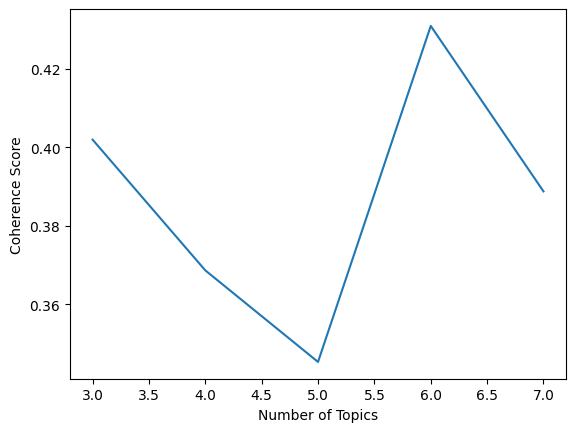

In [184]:
plot_coherence(Abarth_C)

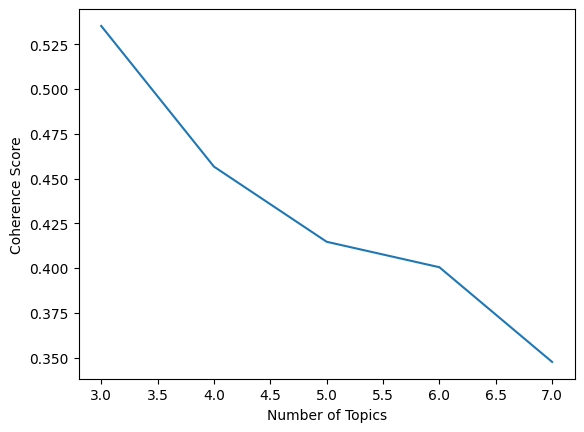

In [185]:
plot_coherence(Fiat_C)

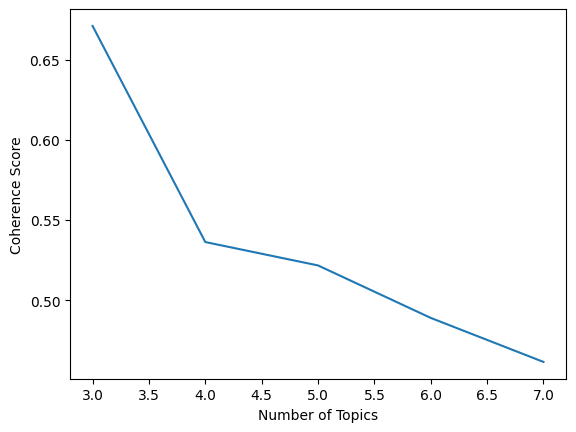

In [186]:
plot_coherence(Tesla_C)

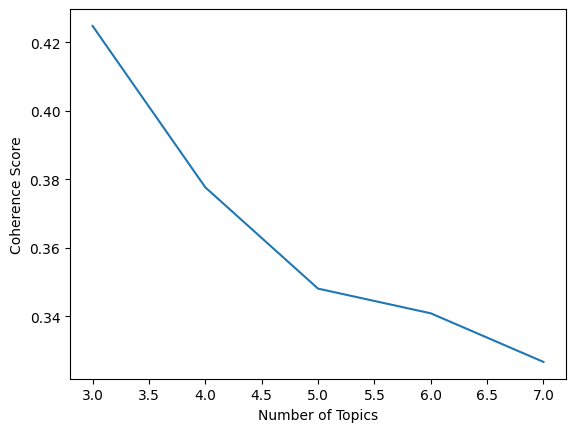

In [187]:
plot_coherence(Mini_C)

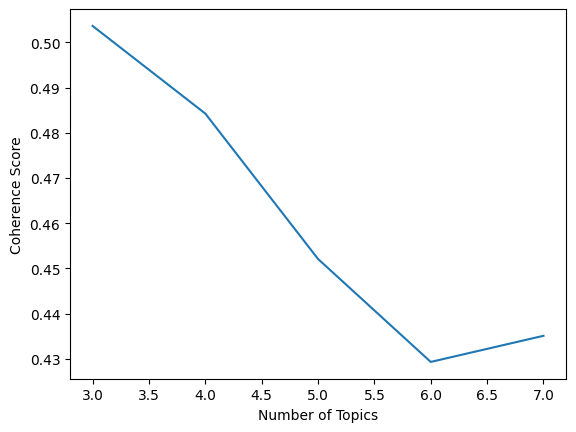

In [188]:
plot_coherence(Volk_C)

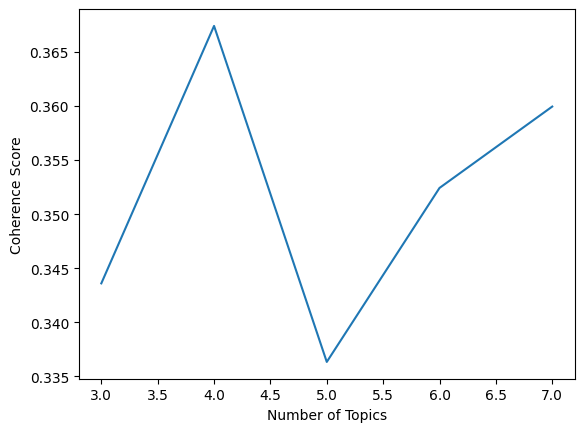

In [189]:
plot_coherence(Peugeot_C)

#4 topics is chosen as the coherence score is not far from the higher 7

Pyldavis Visualisation and top comments for each topics

In [381]:
# Get the document-to-topic probabilities
def get_document_to_topic(model, corpus):
    doc_to_topic = []
    for doc in corpus:
        topics = model.get_document_topics(doc, minimum_probability=0)
        doc_topics = [prob for _, prob in topics]
        doc_to_topic.append(doc_topics)
    return pd.DataFrame(doc_to_topic)

# Get the top 5 comments for each topic
def print_top_comments_for_topics(model, doc_to_topic, original_comments):
    num_topics = len(model.show_topics())
    for topic_num in range(num_topics):
        top_comments_idx = doc_to_topic.nlargest(5, topic_num).index
        print(f"Topic {topic_num}:")
        print(model.show_topic(topic_num))
        print("Top 5 Comments:")
        for idx in top_comments_idx:
            print(" ".join(original_comments[idx]))
        print("="*40)

In [382]:
Abarth_doc_to_topic = get_document_to_topic(Abarth_lda_model, Abarth_corpus)
print_top_comments_for_topics(Abarth_lda_model, Abarth_doc_to_topic, Abarth_comments)

#Topic 0: EV Sound and Experience
#Topic 1: Design and Practicality
#Topic 2: Cost and Sustainability

Topic 0:
[('sound', 0.047584035), ('ev', 0.03915324), ('engine', 0.029535297), ('noise', 0.02370068), ('fun', 0.019670676), ('ice', 0.0117862765), ('nice', 0.01158232), ('turn', 0.011242759), ('stupid', 0.007985429), ('idea', 0.0078058676)]
Top 5 Comments:
byd seagull expensive globally geely geometry esuv aka kung fu cow example great fun funky ultra price disruptive chinese ev western anti free market protectionist force determined prevent export worldwide permit cheap ev export floodgate burst open great cheap fun chinese ev seagull geely geometry kung fu cow scandalously cost china finally wake wickedly angry noise zzz generations task doubt paul
sound low speed protect road user din child false infantile pity mentality customer turn aim
agree engine noise gear change simulation alternate engine noise cool add handbrake fake clutch fake gear lever software map
fake engine noise dunno fan hate guitar chord old immediately idea noise theory fake ice noise definitely music thank effor

In [383]:
Fiat_doc_to_topic = get_document_to_topic(Fiat_lda_model, Fiat_corpus)
print_top_comments_for_topics(Fiat_lda_model, Fiat_doc_to_topic, Fiat_comments)

#Topic 0: Ownership Experience and Practicality
#Topic 1: Aesthetics
#Topic 2: Range, Battery, and Efficiency

Topic 0:
[('buy', 0.030819094), ('drive', 0.030311229), ('year', 0.017254654), ('watch', 0.009783393), ('cost', 0.009211367), ('fun', 0.0077005797), ('km', 0.0074932273), ('old', 0.0074611977), ('day', 0.0073017864), ('family', 0.007186418)]
Top 5 Comments:
stop russian ukraine russia brother russian propagandist russians try destroy ukrainians ukraine weapon close sky russian rocket kill civilian child thank help ukraine
year today stopping radar stupid fools cell year company stop sell eat hat hydrogen dirty water green hydrogen clean hydrogen dirty company fail year new company fail far company alive past year
better brand new stuck service month technician unable discover solve problem th eprobelm faser switch ok problem arise day try try stop believe stop tunnel motorway best experience
ok let honest buy young couple ok kid seat bring use kid rear seat kid grow staggering use university sport truth uncle year daily man huge forgot tender family huge suv fact mile year mileage suv 

In [384]:
Mini_doc_to_topic = get_document_to_topic(Mini_lda_model, Mini_corpus)
print_top_comments_for_topics(Mini_lda_model, Mini_doc_to_topic, Mini_comments)

#Topic 0: Electric Transition and Technical Aspects
#Topic 1: Pricing, Range, and Market Comparison
#Topic 2: Design, Performance, and Environmental Concerns

Topic 0:
[('electric', 0.030555429), ('cool', 0.01717535), ('use', 0.013850127), ('drive', 0.012460216), ('long', 0.0106986035), ('work', 0.008595042), ('wheel', 0.008463454), ('money', 0.0072864913), ('build', 0.0070149745), ('charge', 0.00686038)]
Top 5 Comments:
electric noise emission fuel cost maintenance cost amazing technology gasoline diesel old pollute technology century hydrogen waste money electric electric truck electric bus electric trash hauler electric snow blower electric lawn mower electric snow mobile electric water craft electric garden tool electric mechanic tool electric motor cycle electric bicycle electric scooter electric farm tractor electric construction equipment electric delivery electric worry sit month gas repair
na chinese guy pout garinty testing figure fast running mean super heat mean sloppy frome hard expert machine coldheader run screw titanium screw pop cut place header wire transfer grab cut red hot cold die load fire cracker bangs pop transfer dro

In [385]:
Tesla_doc_to_topic = get_document_to_topic(Tesla_lda_model, Tesla_corpus)
print_top_comments_for_topics(Tesla_lda_model, Tesla_doc_to_topic, Tesla_comments)

#Topic 0: Hydrogen vs Electric
#Topic 1: Engines, Batteries, and Environmental Impact
#Topic 2: EV market and competitors

Topic 0:
[('hydrogen', 0.12709059), ('electric', 0.039552823), ('power', 0.022634909), ('cost', 0.013532576), ('tank', 0.010907592), ('big', 0.009741916), ('oil', 0.009268309), ('motor', 0.008286831), ('electricity', 0.007966182), ('efficient', 0.0068283165)]
Top 5 Comments:
tank turn dumb idea tread turn spin slide friction wich familiar winter slide uncontrollably tank turn summer grippy road shit ton energy ruin tire kick debris dangerous high wheelspeed compare happy winter sliding incline bet end downhill regardle turning intention compensate issue tread wheel dumb idea spin stationary tire use ancor control turn ruin tank turn idea bit feel rotary axis pretty center simulate controllable fashion swich anchor wheel avrg turn middle spin tire pretty instantly imagine multiple burnout tire turn cooler break tire wirk anchor spin bit anymore roll turn prop read far hope enjoy quick excourse dumb idea tankturn wheel
high low usually refer voltage dc power circuit imagine sticky stuff 

In [386]:
Volk_doc_to_topic = get_document_to_topic(Volkswagen_lda_model, Volkswagen_corpus)
print_top_comments_for_topics(Volkswagen_lda_model, Volk_doc_to_topic, Volkswagen_comments)

#Topic 0: Design
#Topic 1: Pricing
#Topic 2: Driving experience and features

Topic 0:
[('design', 0.016372489), ('van', 0.014622519), ('screen', 0.010939787), ('sell', 0.008603998), ('day', 0.008587874), ('yes', 0.008402588), ('seat', 0.008045605), ('manufacturer', 0.007904631), ('market', 0.007867214), ('engine', 0.007583914)]
Top 5 Comments:
fsd design wrong day fix safety white paper describe fsd weather safety temperature altitude define fsd track sensor mount read temp road surface instal cost temp road surface allow fsd change temp close freezing outside temp temp windshield important bet elon thermometer attach windshield detect freezing condition fsd total disaster buck common sense engineering monumental difference autonomous driving run driver
economic balance talk billion asians africa billion south america million eastern europe million south eastern europe million southern europe million billion canada million australia new zealand million usa million western europe gas million million island iceland greenland etc billion overall
model ys usa contr

In [387]:
Peugeot_doc_to_topic = get_document_to_topic(Peugeot_lda_model, Peugeot_corpus)
print_top_comments_for_topics(Peugeot_lda_model, Peugeot_doc_to_topic, Peugeot_comments)

#0. Design and variants
#1. Features and pricing
#2. Driving experience and range
#3. General impressions

Topic 0:
[('french', 0.028481822), ('version', 0.019836595), ('wait', 0.015999634), ('drive', 0.014250135), ('big', 0.011671511), ('awesome', 0.011186154), ('long', 0.009245628), ('beautiful', 0.008933399), ('gt', 0.008391012), ('cost', 0.008387703)]
Top 5 Comments:
suv baffle unimaginative establish automaker xd sayin shrimp fruit sea barbecue boil broil bake saute dey uh shrimp kabob shrimp creole shrimp gumbo pan fry deep fry stir fry pineapple shrimp lemon shrimp coconut shrimp pepper shrimp shrimp soup shrimp stew shrimp salad shrimp potato shrimp burger shrimp sandwich bubba forest gump
aneise girl beach brain girl woman ali world speak foi american woman life beautiful woman die life speak poder comunication diferent eye speak ir
year impress concept creation somebody woke guess wow hype introduction ugly look having metal roller high school shop class ps notice word beauty pss wear sneaker
spend true money spend happy practical object safely comfort quick nice look cost half sp

In [208]:
# Visualize Abarth model
Abarth_vis = gensimvis.prepare(Abarth_lda_model, Abarth_corpus, Abarth_id2word)
pyLDAvis.display(Abarth_vis)

In [209]:
# Visualize Fiat model
Fiat_vis = gensimvis.prepare(Fiat_lda_model, Fiat_corpus, Fiat_id2word)
pyLDAvis.display(Fiat_vis)

In [210]:
# Visualize Tesla model
Tesla_vis = gensimvis.prepare(Tesla_lda_model, Tesla_corpus, Tesla_id2word)
pyLDAvis.display(Tesla_vis)

In [211]:
# Visualize Mini model
Mini_vis = gensimvis.prepare(Mini_lda_model, Mini_corpus, Mini_id2word)
pyLDAvis.display(Mini_vis)

In [212]:
# Visualize Volkswagen model
Volkswagen_vis = gensimvis.prepare(Volkswagen_lda_model, Volkswagen_corpus, Volkswagen_id2word)
pyLDAvis.display(Volkswagen_vis)

In [213]:
# Visualize Peugeot model
Peugeot_vis = gensimvis.prepare(Peugeot_lda_model, Peugeot_corpus, Peugeot_id2word)
pyLDAvis.display(Peugeot_vis)

Timeline graphs

In [280]:
# Convert the 'Date' column to datetime type
Abarth['Date'] = pd.to_datetime(Abarth['Date'])
Fiat['Date'] = pd.to_datetime(Fiat['Date'])
Tesla['Date'] = pd.to_datetime(Tesla['Date'])
Mini['Date'] = pd.to_datetime(Mini['Date'])
Volkswagen['Date'] = pd.to_datetime(Volkswagen['Date'])
Peugeot['Date'] = pd.to_datetime(Peugeot['Date'])


# Extract the year-month
Abarth['Year_Month'] = Abarth['Date'].dt.to_period('M')
Fiat['Year_Month'] = Fiat['Date'].dt.to_period('M')
Tesla['Year_Month'] = Tesla['Date'].dt.to_period('M')
Mini['Year_Month'] = Mini['Date'].dt.to_period('M')
Volkswagen['Year_Month'] = Volkswagen['Date'].dt.to_period('M')
Peugeot['Year_Month'] = Peugeot['Date'].dt.to_period('M')

/var/folders/yt/slyrm7113271w310_rtxsbnw0000gn/T/ipykernel_37933/2645143372.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Abarth['Date'] = pd.to_datetime(Abarth['Date'])
/var/folders/yt/slyrm7113271w310_rtxsbnw0000gn/T/ipykernel_37933/2645143372.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Fiat['Date'] = pd.to_datetime(Fiat['Date'])
/var/folders/yt/slyrm7113271w310_rtxsbnw0000gn/T/ipykernel_37933/2645143372.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [372]:
def get_relevant_topics(lda_model, comment, threshold=False):
    topics = lda_model.get_document_topics(comment)
    return [(topic[0], topic[1]) for topic in topics if topic[1] >= threshold]

Abarth_doc_topics = [get_relevant_topics(Abarth_lda_model, comment) for comment in Abarth_corpus]
Fiat_doc_topics = [get_relevant_topics(Fiat_lda_model, comment) for comment in Fiat_corpus]
Tesla_doc_topics = [get_relevant_topics(Tesla_lda_model, comment) for comment in Tesla_corpus]
Mini_doc_topics = [get_relevant_topics(Mini_lda_model, comment) for comment in Mini_corpus]
Volk_doc_topics = [get_relevant_topics(Volkswagen_lda_model, comment) for comment in Volkswagen_corpus]
Peugeot_doc_topics = [get_relevant_topics(Peugeot_lda_model, comment) for comment in Peugeot_corpus]

In [373]:
# 1. Modify the DataFrame to accept lists of topics.
Abarth['Topics'] = Abarth_doc_topics
Fiat['Topics'] = Fiat_doc_topics
Tesla['Topics'] = Tesla_doc_topics
Mini['Topics'] = Mini_doc_topics
Volkswagen['Topics'] = Volk_doc_topics
Peugeot['Topics'] = Peugeot_doc_topics

# Helper function to count topic occurrences by year-month.
def count_topics_by_year_month(df):
    all_sums = []
    grouped = df.groupby('Year_Month')
    for name, group in grouped:
        for topic_num in set(topic for topics in group['Topics'] for topic, _ in topics):
            topic_prob_sum = sum(prob for topics in group['Topics'] for topic, prob in topics if topic == topic_num)
            all_sums.append((name, topic_num, topic_prob_sum))
    return pd.DataFrame(all_sums, columns=['Year_Month', 'Topic', 'Sum_Probability'])

# 2. Count occurrences of each topic by year-month.
topic_counts_by_year_Abarth = count_topics_by_year_month(Abarth)
topic_counts_by_year_Fiat = count_topics_by_year_month(Fiat)
topic_counts_by_year_Tesla = count_topics_by_year_month(Tesla)
topic_counts_by_year_Mini = count_topics_by_year_month(Mini)
topic_counts_by_year_Volkswagen = count_topics_by_year_month(Volkswagen)
topic_counts_by_year_Peugeot = count_topics_by_year_month(Peugeot)

# 3. Filter datasets if required
topic_counts_by_year_Abarth = topic_counts_by_year_Abarth[topic_counts_by_year_Abarth['Year_Month'] > pd.Period('2019-12')]
topic_counts_by_year_Fiat = topic_counts_by_year_Fiat[topic_counts_by_year_Fiat['Year_Month'] > pd.Period('2016-12')]

/var/folders/yt/slyrm7113271w310_rtxsbnw0000gn/T/ipykernel_37933/2762588132.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Abarth['Topics'] = Abarth_doc_topics
/var/folders/yt/slyrm7113271w310_rtxsbnw0000gn/T/ipykernel_37933/2762588132.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Fiat['Topics'] = Fiat_doc_topics
/var/folders/yt/slyrm7113271w310_rtxsbnw0000gn/T/ipykernel_37933/2762588132.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

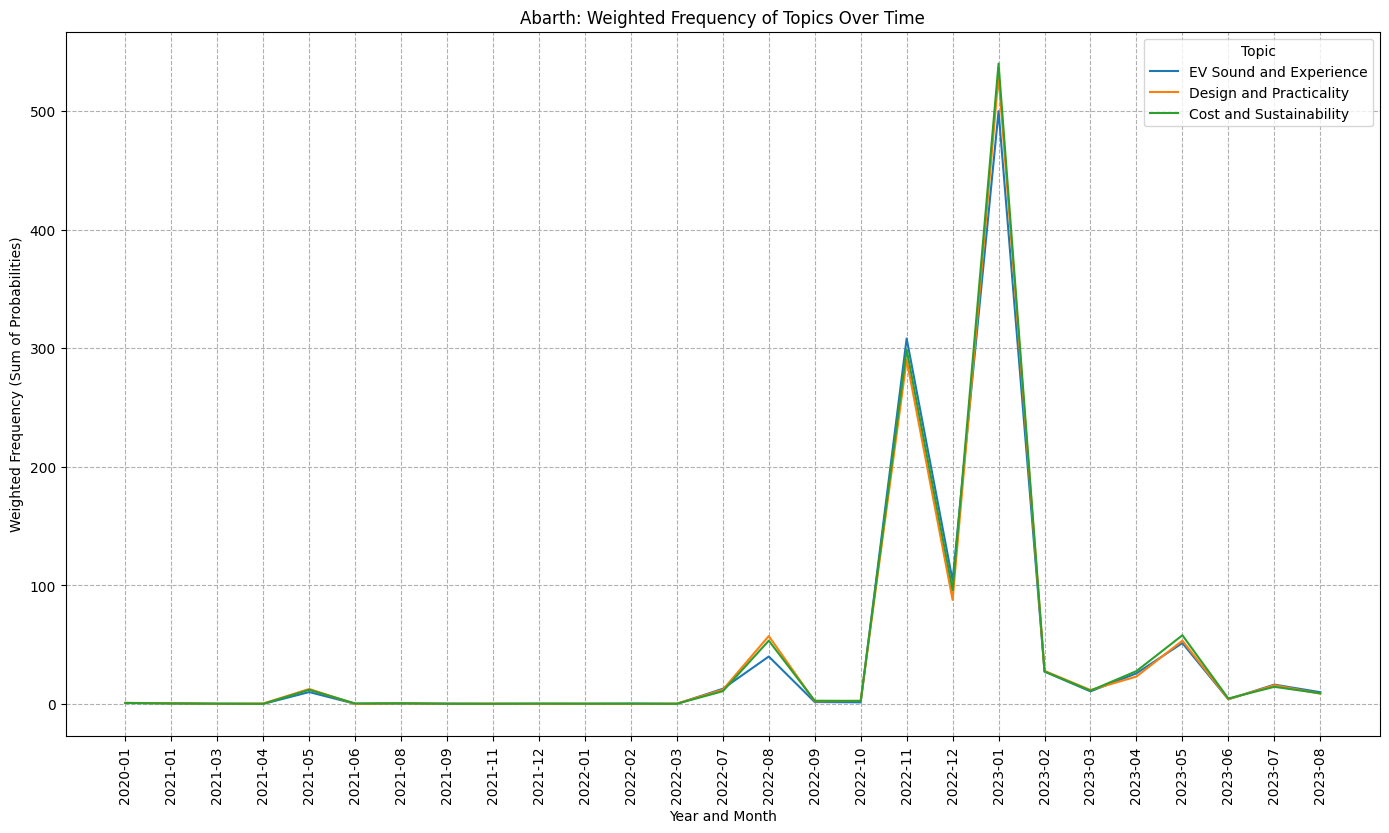

In [374]:
topic_names_abarth = {
    0: 'EV Sound and Experience',
    1: 'Design and Practicality',
    2: 'Cost and Sustainability'
}

topic_counts_by_year_Abarth['Topic'] = topic_counts_by_year_Abarth['Topic'].replace(topic_names_abarth)

topic_counts_by_year_Abarth['Year_Month'] = topic_counts_by_year_Abarth['Year_Month'].astype(str)

plt.figure(figsize=(14, 8))
sns.lineplot(data=topic_counts_by_year_Abarth, x='Year_Month', y='Sum_Probability', hue='Topic')
plt.title('Abarth: Weighted Frequency of Topics Over Time')
plt.xlabel('Year and Month')
plt.ylabel('Weighted Frequency (Sum of Probabilities)')
plt.legend(title='Topic')
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.show()

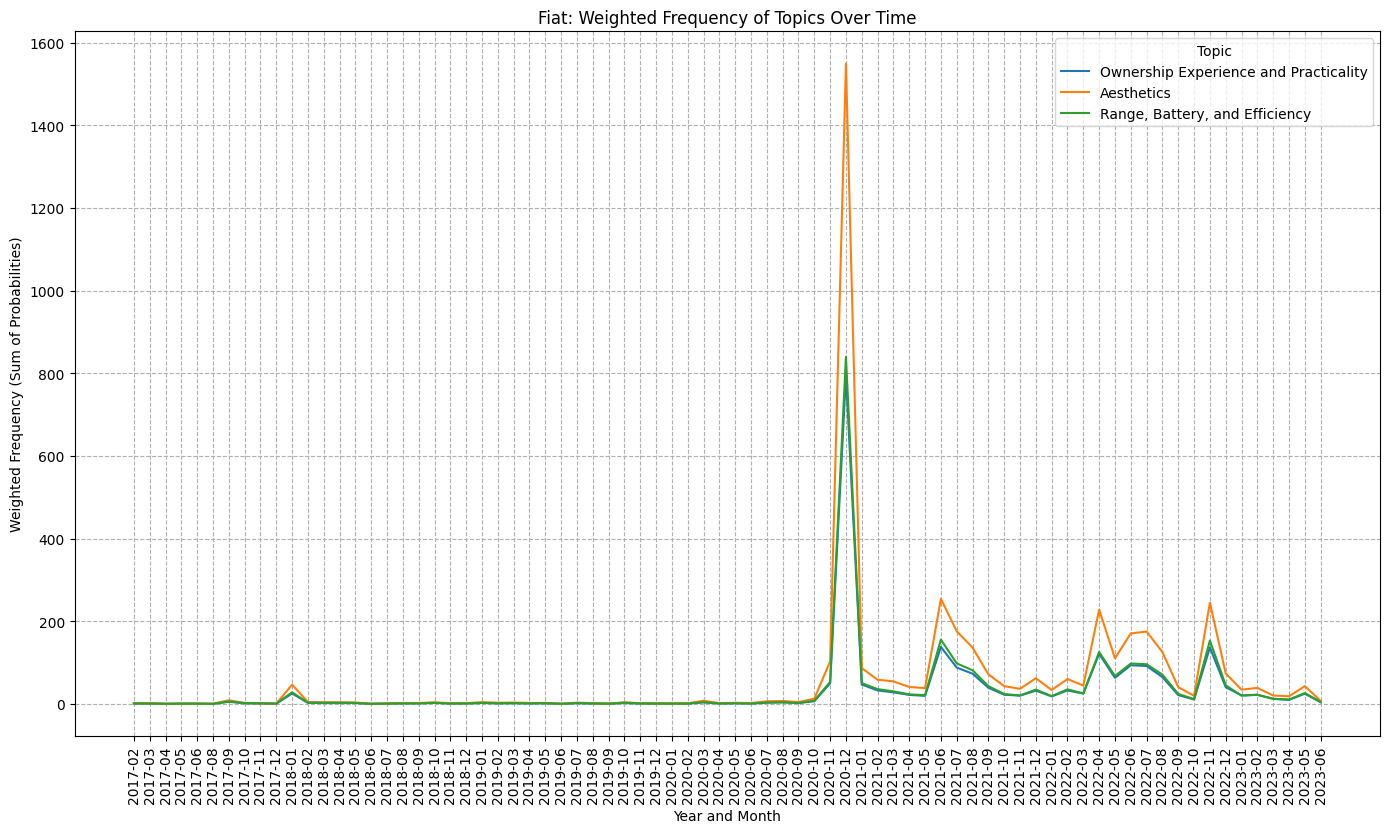

In [375]:
topic_names_Fiat = {
     0: 'Ownership Experience and Practicality',
     1: 'Aesthetics',
     2: 'Range, Battery, and Efficiency'
}

topic_counts_by_year_Fiat['Topic'] = topic_counts_by_year_Fiat['Topic'].replace(topic_names_Fiat)


# Convert the PeriodIndex to string
topic_counts_by_year_Fiat['Year_Month'] = topic_counts_by_year_Fiat['Year_Month'].astype(str)


plt.figure(figsize=(14, 8))
sns.lineplot(data=topic_counts_by_year_Fiat, x='Year_Month', y='Sum_Probability', hue='Topic')
plt.title('Fiat: Weighted Frequency of Topics Over Time')
plt.xlabel('Year and Month')
plt.ylabel('Weighted Frequency (Sum of Probabilities)')
plt.legend(title='Topic')
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.show()

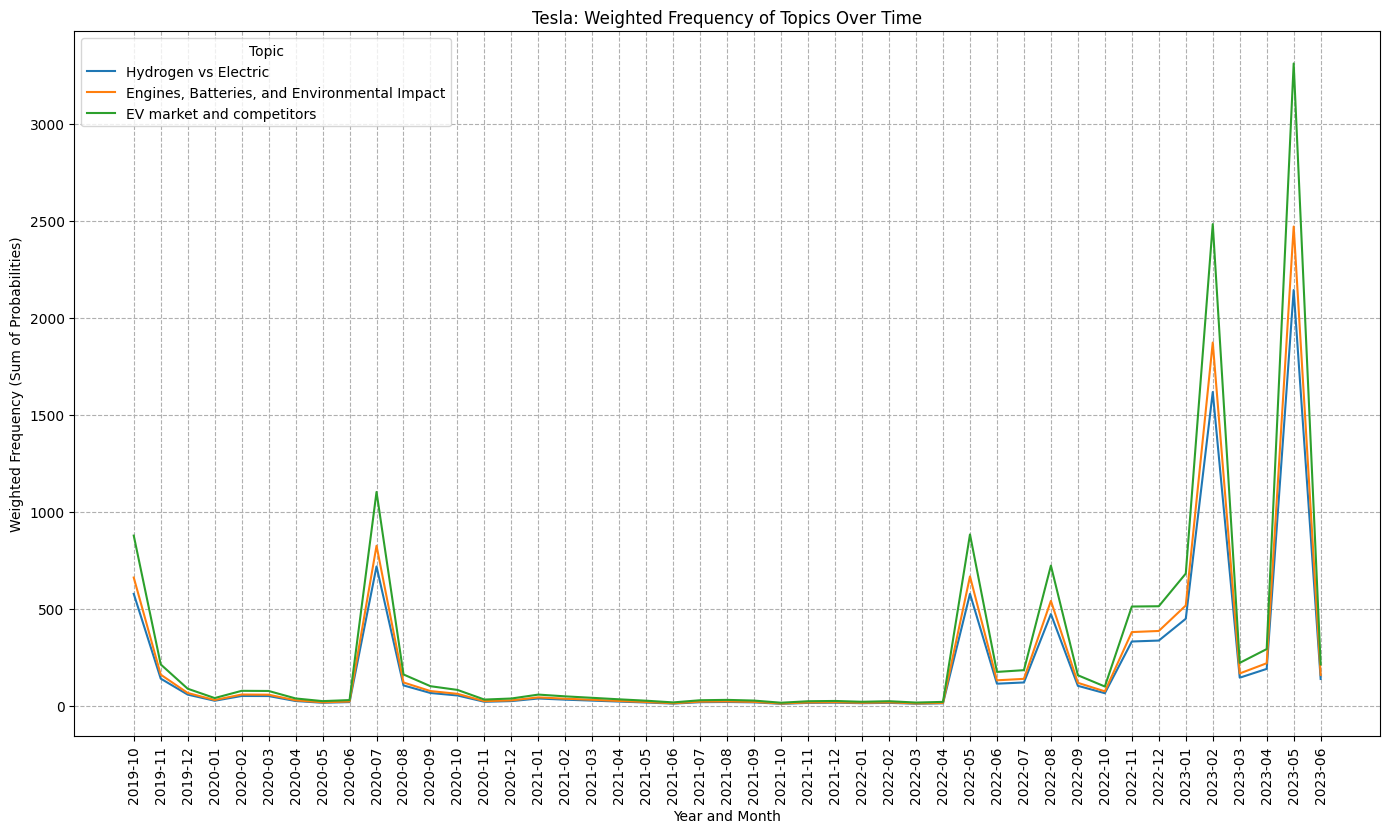

In [376]:
topic_names_Tesla = {
    0: 'Hydrogen vs Electric',
    1: 'Engines, Batteries, and Environmental Impact',
    2: 'EV market and competitors'
}

topic_counts_by_year_Tesla['Topic'] = topic_counts_by_year_Tesla['Topic'].replace(topic_names_Tesla)

# Convert the PeriodIndex to string
topic_counts_by_year_Tesla['Year_Month'] = topic_counts_by_year_Tesla['Year_Month'].astype(str)


plt.figure(figsize=(14, 8))
sns.lineplot(data=topic_counts_by_year_Tesla, x='Year_Month', y='Sum_Probability', hue='Topic')
plt.title('Tesla: Weighted Frequency of Topics Over Time')
plt.xlabel('Year and Month')
plt.ylabel('Weighted Frequency (Sum of Probabilities)')
plt.legend(title='Topic')
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.show()

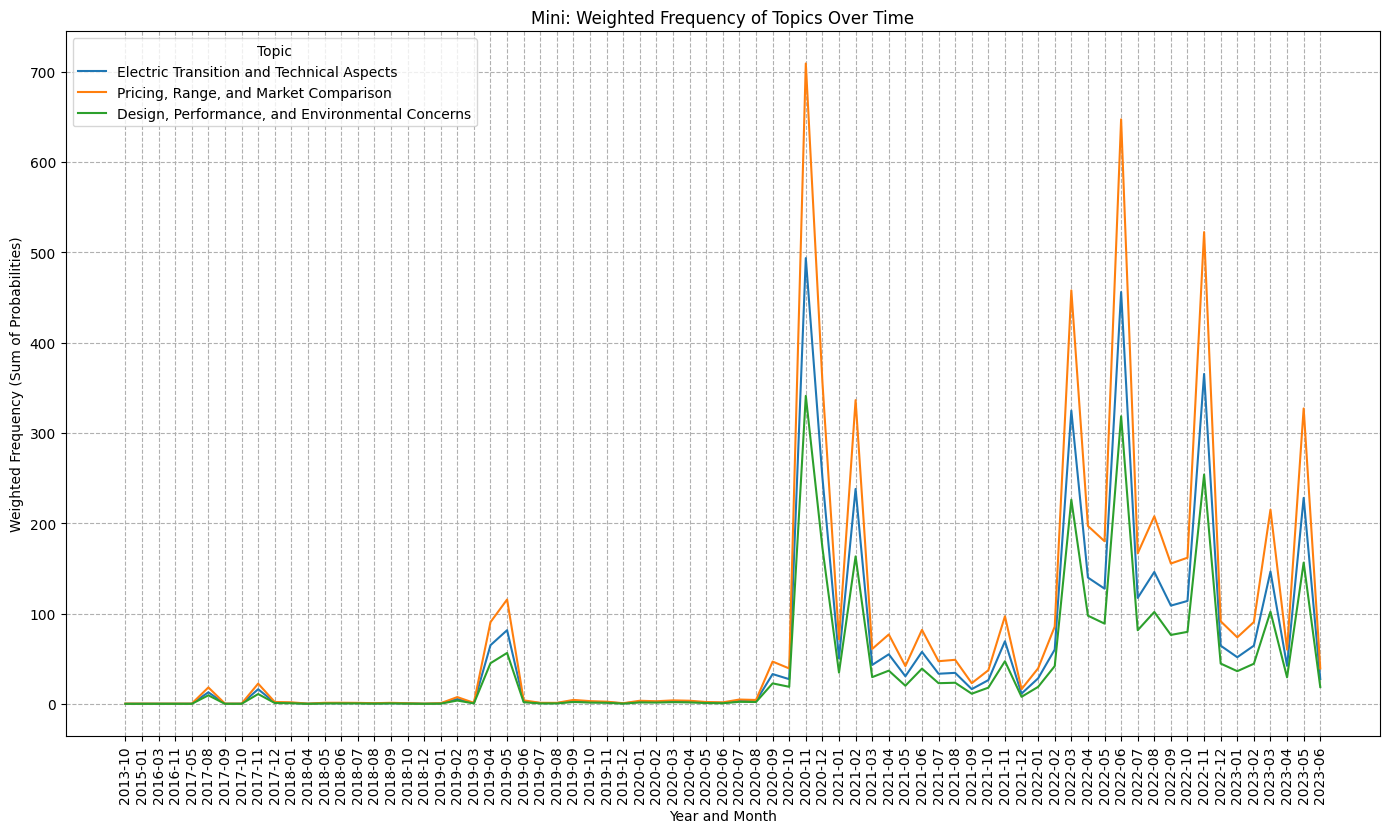

In [377]:
topic_names_Mini = {
    0: 'Electric Transition and Technical Aspects',
    1: 'Pricing, Range, and Market Comparison',
    2: 'Design, Performance, and Environmental Concerns'
}

topic_counts_by_year_Mini['Topic'] = topic_counts_by_year_Mini['Topic'].replace(topic_names_Mini)


# Convert the PeriodIndex to string
topic_counts_by_year_Mini['Year_Month'] = topic_counts_by_year_Mini['Year_Month'].astype(str)


plt.figure(figsize=(14, 8))
sns.lineplot(data=topic_counts_by_year_Mini, x='Year_Month', y='Sum_Probability', hue='Topic')
plt.title('Mini: Weighted Frequency of Topics Over Time')
plt.xlabel('Year and Month')
plt.ylabel('Weighted Frequency (Sum of Probabilities)')
plt.legend(title='Topic')
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.show()

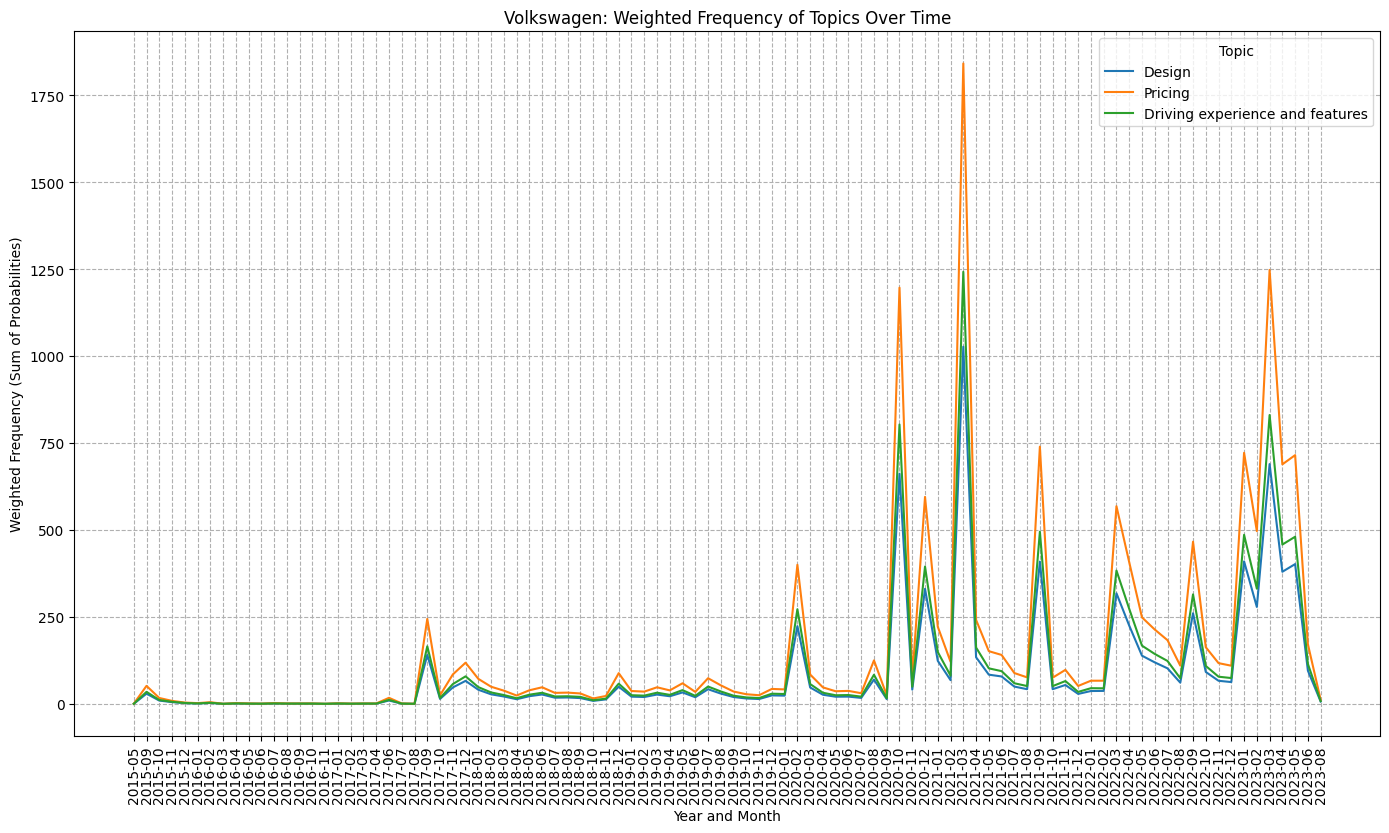

In [378]:
topic_names_Volk = {
   0: 'Design',
   1: 'Pricing',
   2: 'Driving experience and features'
}

topic_counts_by_year_Volkswagen['Topic'] = topic_counts_by_year_Volkswagen['Topic'].replace(topic_names_Volk)

# Convert the PeriodIndex to string
topic_counts_by_year_Volkswagen['Year_Month'] = topic_counts_by_year_Volkswagen['Year_Month'].astype(str)


plt.figure(figsize=(14, 8))
sns.lineplot(data=topic_counts_by_year_Volkswagen, x='Year_Month', y='Sum_Probability', hue='Topic')
plt.title('Volkswagen: Weighted Frequency of Topics Over Time')
plt.xlabel('Year and Month')
plt.ylabel('Weighted Frequency (Sum of Probabilities)')
plt.legend(title='Topic')
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.show()

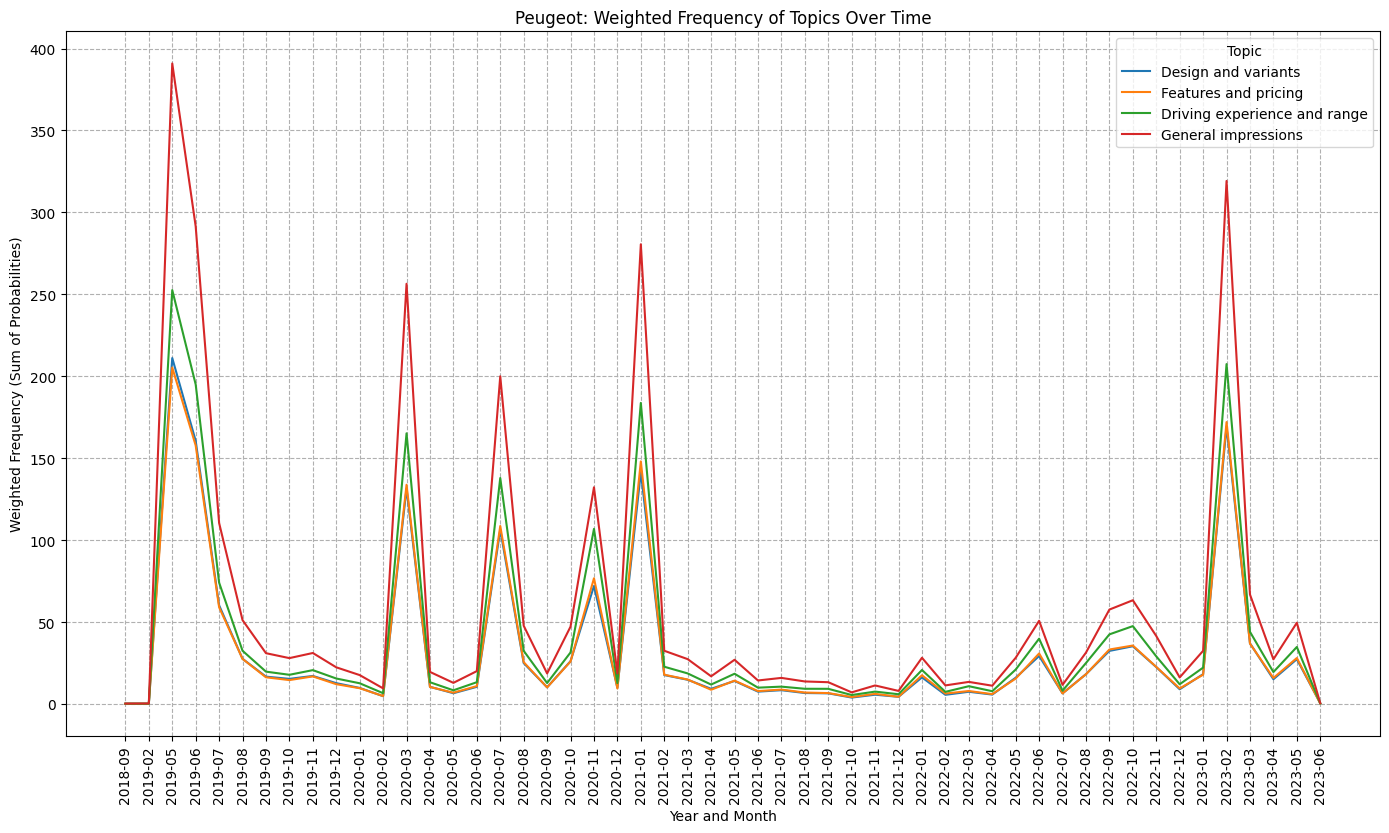

In [379]:
topic_names_Peugeot = {
  0: 'Design and variants',
  1: 'Features and pricing',
  2: 'Driving experience and range',
  3: 'General impressions'
}

topic_counts_by_year_Peugeot['Topic'] = topic_counts_by_year_Peugeot['Topic'].replace(topic_names_Peugeot)

# Convert the PeriodIndex to string
topic_counts_by_year_Peugeot['Year_Month'] = topic_counts_by_year_Peugeot['Year_Month'].astype(str)

plt.figure(figsize=(14, 8))
sns.lineplot(data=topic_counts_by_year_Peugeot, x='Year_Month', y='Sum_Probability', hue='Topic')
plt.title('Peugeot: Weighted Frequency of Topics Over Time')
plt.xlabel('Year and Month')
plt.ylabel('Weighted Frequency (Sum of Probabilities)')
plt.legend(title='Topic')
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.show()